# Statistics

In [1]:
import numpy as np
from scipy.stats import poisson as pois
from scipy.stats import norm
import matplotlib.pyplot as plt

import nbimporter
import prepData as prep
import fitFunc as fits

## Significance Test

We want to compute the significance of the observed dataset.  
The first steps are rescaling the dataset and fitting the background and signal functions.

We then compute the likelihood ratio of the observed data $q_0^{obs}$ between the signal and null hypothesis:

$$q_0^{obs} = -2 \cdot \log \left( \cfrac{\mathcal{L} \left(Data | 0, \hat{\theta}_0 \right)}{\mathcal{L} \left(Data | \hat{\mu}, \hat{\theta}_\hat{\mu} \right)}\right)$$

The ^ symbol indicates the values that optimize the fits.

In [2]:
# compute likelihood ratios of two hypotheses
def lh_ratio(y, null_vals, alt_vals, N=1365500):
    # compute log likelihoods
    LogLike_null = sum(norm.logpdf(x=y, loc=null_vals, scale=prep.calc_weights(null_vals, N)))
    LogLike_alt  = sum(norm.logpdf(x=y, loc=alt_vals,  scale=prep.calc_weights(alt_vals,  N)))
    
    #LogLike_null = sum(pois.logpmf(fft.astype(int), model_null.best_fit.astype(int)))
    #LogLike_alt  = sum(pois.logpmf(fft.astype(int), model_alt.best_fit.astype(int)))
    
    # ratio
    q = -2 * (LogLike_null - LogLike_alt)
    
    return q

The value of $q_0^{obs}$ has no meaning by itself, so we generate n = 10,000 toy datasets from the expected values given by the background fit and repeate the analysis for every new dataset. Both for the likelihood ratio and for the toy dataset generation, a normal approximation has been used instead of the formal Poisson distribution. 

In [3]:
def gen_toydataset(values, n, N=1365500):
    toy_dataset = norm.rvs(loc=values, scale=prep.calc_weights(values, N), size=(n, len(values)))
    
    #toy_dataset = pois.rvs(mu=values, size=(n,len(values)))
    
    return toy_dataset

The original $q_0^{obs}$ is thus compared with the distribution of $q_0$ obtained from the toy datasets, and the p-value is computed:

$$p_0 = P \left( q_0 \ge q_0^{obs} \right) = \int_{q_0^{obs}}^{+\infty} f(q_0 | 0, \hat{\theta}_0) \,dx $$ 

The significance is expressed as the number of $\sigma$s needed to achieve an equivalent p-value in a standard normal deviation:

$$z = \Phi^{-1} \left(1 - p_0 \right)$$  

In [4]:
def p_value(q_obs, q):
    p0 = sum(q >= q_obs)/len(q)
    return p0

This process is repeted using every possible frequency as $x_0$, the center of the signal function.  
The complete code is:

In [5]:
def sig_test(run, signal, path='db/', n=10000):
    # load and prep data
    data, center, length = prep.load_dataset(run, path)
    freq, fft, weights, ref = prep.prep_data(data, center, length=length)
    
    # fit background once
    res_bkg = fits.fit_bkg(x=freq, y=fft, w=weights, center=center, ref=ref)
    
    # scan x0
    z = np.zeros(len(freq))
    for i in range(len(freq)):
        _, z[i] = significance(x=freq, y=fft, w=weights,
                               bkg=res_bkg, center=center, ref=ref,
                               x_0=freq.values[i], signal=signal, n_toy=n)    
    return z

In [6]:
def significance2(x, y, w, bkg, center, ref, x_0, signal, n_toy=10000, draw=False):
    res_sig = fits.fit_sig(x, y, w, x_0, bkg, signal).best_fit
    
    # compute likelihood ratio of observed data
    q0_obs = lh_ratio(y, bkg, res_sig)
    
    # generate toy datasets and compute likelihood ratio for all of them
    toy_y = gen_toydataset(values=bkg.best_fit, n=n_toy)
    toy_w = prep.calc_weights(toy_y)
    
    q0 = np.zeros(n)
    for i in range(n):
        toy_bkg = fits.fit_bkg(x=x, y=toy_y[i], w=toy_w[i], center=center, ref=ref)    
        toy_sig = fits.fit_sig(x=x, y=toy_y[i], w=toy_w[i], x_0=x_0, bkg=toy_bkg, signal=signal)
        q0[i] = lh_ratio(toy_y[i], toy_bkg, toy_sig)
    
    # plot significance distribution
    if(draw):
        plot_significance(q0_obs, q0)
        
    # compute significance
    p0 = p_value(q0_obs, q0)
    z = norm.ppf(1-p0)
        
    return q0, z

In [7]:
def plot_significance(q_obs, q):
    # prepare canvas
    fig = plt.figure(figsize=(15,10))
    
    # plot q0 distribution
    N = len(q)
    binning = int(np.sqrt(N))
    n, bins, _ = plt.hist(q, bins=binning, density = True, 
                          facecolor='lightblue', edgecolor='black', label='Toy Experiments')
    plt.vlines(q_obs, 0, max(n), colors='blue', linestyles='--', label='Observed Data')
    
    plt.legend(loc='upper left')
    plt.xlabel('q')
    plt.ylabel('PDf')
    
    plt.show()

## Confidence Intervals

The process is similar to that of the significance test, but with a few key differences.  

In addition to fitting the background, we fit the signal twice: one time we let the $\mu$ run free to find $\hat{\mu}$, while the other we keep it fixed to a certain value.  
The likelihood ratio is thus computed as:

$$q^{obs}(\mu) = -2 \cdot \log \left( \cfrac{\mathcal{L} \left(Data | \mu, \hat{\theta}_{\mu} \right)}{\mathcal{L} \left(Data | \hat{\mu}, \hat{\theta}_\hat{\mu} \right)}\right)$$

We then generate two sets of n = 10,000 toy datasets each, one as before from the expected values given by the background fit while the other from the signal fit with fixed $\mu$. We compare the original $q^{obs}(\mu)$ with the distribution of $q(0)$ and $q(\mu)$ from the toy datasets and compute the two probabilities:

$$    p_{\mu} = P \left(q(\mu) \ge q^{obs}(\mu) | \mu s + b \right)$$
$$1 - p_{b}   = P \left(q(\mu) \ge q^{obs}(\mu) | b \right)$$

and take their ratio.  
This process is done scanning different values of $\mu$ and we take as the 95% confidence interval limit the value of $\mu$ so that the ratio is equal to 0.05:

$$CL: \mu \; \big| \; \cfrac{p_{\mu}}{1 - p_{b}} = 0.05$$

This process is repeted using every possible frequency as $x_0$, the center of the signal function.

In [8]:
def CI_test(run, signal, path='db/', n=10000):
    # load and prep data
    data, center, length = prep.load_dataset(run, path)
    freq, fft, weights, ref = prep.prep_data(data, center, length=length)
    
    # fit background once
    res_bkg = fits.fit_bkg(x=freq, y=fft, w=weights, center=center, ref=ref)
    
    # scan x0
    mu_ci = np.zeros(len(freq))
    for i in range(len(freq)):
        mu_ci[i] = CI(freq, fft, weights, center, freq.values[i], res_bkg, signal, n)
    
    return(mu_ci)

In [9]:
def CI(x, y, w, bkg, center, ref, mu_fix, x_0, signal, n_toy=10000, draw=False, verbose=False):
    
    
    # scan for mu
    r = np.zeros(len(mu_vals))
    for i in range(len(r)):
        res_fix = fits.fit_sig(freq, fft, weights, x_0, res_bkg, signal, mu_init = mu_vals[i], mu_vary = False)
        res_sig = fits.fit_sig(freq, fft, weights, x_0, res_bkg, signal)
        
        # compute likelihood ratio of observed data
        q_mu_obs = lh_ratio(fft, res_fix, res_sig)
        
        # generate toy datasets and compute likelihood ratio
        
        # fixed mu
        toy_fft_mu     = gen_toydataset(res_fix.best_fit, n)
        toy_weights_mu = toy_fft_mu/np.sqrt(1365500) # NOT UP TO DATE !!!!!!!!!!!!!!!!
        q_mu   = np.zeros(n)
        for j in range(n):
            toy_bkg = fits.fit_bkg(freq, toy_fft_mu[j], toy_weights_mu[j], center, ref)
            toy_fix = fits.fit_sig(freq, toy_fft_mu[j], toy_weights_mu[j], x_0, toy_bkg, signal,
                                   mu_init = mu_vals[i], mu_vary = False)
            toy_sig = fits.fit_sig(freq, toy_fft_mu[j], toy_weights_mu[j], x_0, toy_bkg, signal)
            q_mu[i] = lh_ratio(toy_fft_mu[j], toy_fix, toy_sig)
        
        # background
        toy_fft_bkg     = gen_toydataset(res_bkg.best_fit, n)
        toy_weights_bkg = toy_fft_bkg/np.sqrt(1365500) # NOT UP TO DATE !!!!!!!!!!!!!!!!
        q0   = np.zeros(n)
        for j in range(n):
            toy_bkg = fits.fit_bkg(freq, toy_fft_bkg[j], toy_weights_bkg[j], center, ref)
            toy_sig = fits.fit_sig(freq, toy_fft_bkg[j], toy_weights_bkg[j], x_0, toy_bkg, signal)
            q0[j] = lh_ratio(toy_fft_bkg[j], toy_bkg, toy_sig)
        
        # compute p-values
        p_mu = p_value(q_mu, q_mu_obs)
        p_b  = p_value(q0, q_mu_obs)
        
        # compute ratio
        r[i] = p_mu/p_b
        
        if(verbose):
            print("Mu: ", mu_vals[i], "\np_mu =", p_mu, "  p_b =", p_b, "  ratio =", r[i], "\n")
    
    idx = np.argmin(np.abs(r - 0.05))
        
    return(mu_vals[idx])

In [10]:
def stat_test(run, signal, x_0, path='db/', n_toy=10000, calc_z=False, calc_CI=False):
    
    # load and prep data
    data, center, length = prep.load_dataset(run, path)
    freq, fft, weights, ref, N = prep.prep_data(data, center, length=length)
    
    # fit background once
    res_bkg = fits.fit_bkg(x=freq, y=fft, w=weights, center=center, ref=ref)
    
    # generate toy datasets from bkg and fit them
    toy = gen_toydataset(values=res_bkg.best_fit, n=n_toy, N=N)
    res_toy_bkg = []
    for i in range(n_toy):
        toy_w = prep.calc_weights(toy[i], N)
        res_toy_bkg.append(fits.fit_bkg(x=freq, y=toy[i], w=toy_w, center=center, ref=ref))   
        
    # scan x0 and perform desired tests
    z = np.empty(len(x_0))
    _ = np.empty(len(x_0))
    for i in range(len(x_0)):
        if calc_z:
            z[i] = significance(freq, fft, weights,
                                res_bkg, toy, res_toy_bkg,
                                x_0[i], signal, N, draw=False)
            
            
    return z

In [11]:
def significance(x, y, w, res_bkg, toy, res_toy_bkg, x_0, signal, N=1365500, draw=False):
    
    n_toy = len(toy)
    
    # get results from bkg fit
    bkg        = res_bkg.best_fit
    bkg_params = res_bkg.best_values
    
    # fit signal
    sig = fits.fit_sig(x, y, w, x_0, bkg_params, signal).best_fit
    
    # compute likelihood ratio of observed data
    q0_obs = lh_ratio(y, bkg, sig, N)
    
    # analyze toy datasets
    q0 = np.empty(n_toy)
    for i in range(n_toy):
        # get results from toy bkg fit
        toy_bkg        = res_toy_bkg[i].best_fit
        toy_bkg_params = res_toy_bkg[i].best_values
        
        # compute signal fit over toy dataset
        toy_w = prep.calc_weights(toy[i], N)
        toy_sig = fits.fit_sig(x=x, y=toy[i], w=toy_w, x_0=x_0, init_params=toy_bkg_params, signal=signal).best_fit
        
        # compue likelihood ratio of toy dataset 
        q0[i] = lh_ratio(toy[i], toy_bkg, toy_sig, N)
    
    # plot significance distribution
    if(draw):
        plot_significance(q0_obs, q0)
        
    # compute significance
    p0 = p_value(q0_obs, q0)
    z = norm.ppf(1-p0)
        
    return z

In [ ]:
def CI(x, y, w, bkg, center, ref, mu_fix, x_0, signal, n_toy=10000, draw=False, verbose=False):
    
    
    # scan for mu
    r = np.zeros(len(mu_vals))
    for i in range(len(r)):
        res_fix = fits.fit_sig(freq, fft, weights, x_0, res_bkg, signal, mu_init = mu_vals[i], mu_vary = False)
        res_sig = fits.fit_sig(freq, fft, weights, x_0, res_bkg, signal)
        
        # compute likelihood ratio of observed data
        q_mu_obs = lh_ratio(fft, res_fix, res_sig)
        
        # generate toy datasets and compute likelihood ratio
        
        # fixed mu
        toy_fft_mu     = gen_toydataset(res_fix.best_fit, n)
        toy_weights_mu = toy_fft_mu/np.sqrt(1365500) # NOT UP TO DATE !!!!!!!!!!!!!!!!
        q_mu   = np.zeros(n)
        for j in range(n):
            toy_bkg = fits.fit_bkg(freq, toy_fft_mu[j], toy_weights_mu[j], center, ref)
            toy_fix = fits.fit_sig(freq, toy_fft_mu[j], toy_weights_mu[j], x_0, toy_bkg, signal,
                                   mu_init = mu_vals[i], mu_vary = False)
            toy_sig = fits.fit_sig(freq, toy_fft_mu[j], toy_weights_mu[j], x_0, toy_bkg, signal)
            q_mu[i] = lh_ratio(toy_fft_mu[j], toy_fix, toy_sig)
        
        # background
        toy_fft_bkg     = gen_toydataset(res_bkg.best_fit, n)
        toy_weights_bkg = toy_fft_bkg/np.sqrt(1365500) # NOT UP TO DATE !!!!!!!!!!!!!!!!
        q0   = np.zeros(n)
        for j in range(n):
            toy_bkg = fits.fit_bkg(freq, toy_fft_bkg[j], toy_weights_bkg[j], center, ref)
            toy_sig = fits.fit_sig(freq, toy_fft_bkg[j], toy_weights_bkg[j], x_0, toy_bkg, signal)
            q0[j] = lh_ratio(toy_fft_bkg[j], toy_bkg, toy_sig)
        
        # compute p-values
        p_mu = p_value(q_mu, q_mu_obs)
        p_b  = p_value(q0, q_mu_obs)
        
        # compute ratio
        r[i] = p_mu/p_b
        
        if(verbose):
            print("Mu: ", mu_vals[i], "\np_mu =", p_mu, "  p_b =", p_b, "  ratio =", r[i], "\n")
    
    idx = np.argmin(np.abs(r - 0.05))
        
    return(mu_vals[idx])

In [12]:
data,center,length = prep.load_dataset(395)
freq, fft, weights, ref, N = prep.prep_data(data,center, length=length)
res_bkg = fits.fit_bkg(freq, fft, weights, center, ref)

Dataset loaded: db/AnalyzedDataFFT_Run_395_sliced.xlsx
Cavity frequency: 10353468841.0 Hz
fft subrun:2


In [13]:
# generate toy datasets from bkg and fit them
n_toy = 300
toy = gen_toydataset(values=res_bkg.best_fit, n=n_toy, N=N)
res_toy_bkg = []
for i in range(n_toy):
    toy_w = prep.calc_weights(toy[i], N)
    res_toy_bkg.append(fits.fit_bkg(x=freq, y=toy[i], w=toy_w, center=center, ref=ref))  

In [14]:
q0 = np.empty(n_toy)

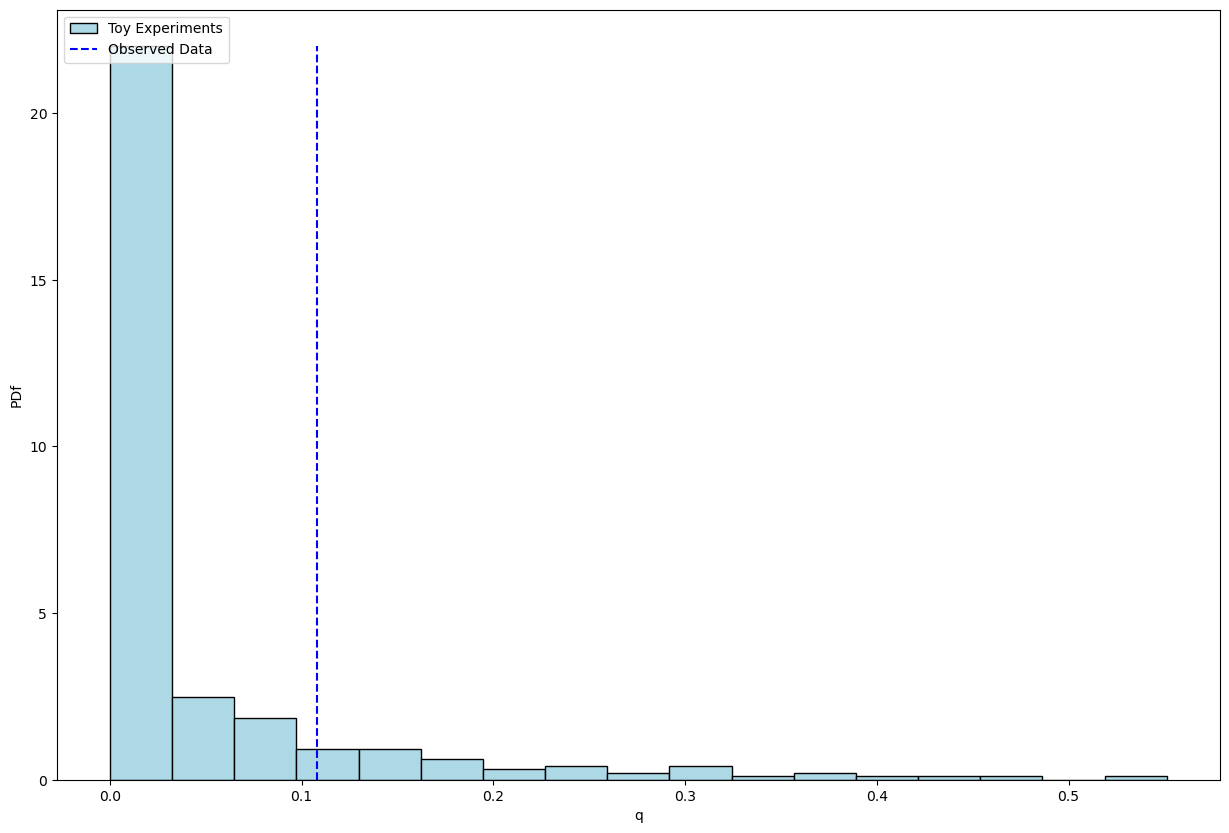

In [15]:
x0_max = 10353409505.208334
z_max = significance(freq, fft, weights,
                     res_bkg, toy, res_toy_bkg,
                     x0_max, fits.signal_gauss, N, draw=True)